## Testing inference

In [4]:
from datasets import data_merge_R
from transformers import *
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from networks import get_model
from networks import SSAN_R
from utils import *
from utils.performance import performance_double_val
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def inference(PATH, img_size=112, type='test', train_datasets='M1', batch_size=256):
    num_workers = 8

    data_bank = data_merge_R.data_merge()
    model = SSAN_R().cuda()
    state = torch.load(PATH)
    model.load_state_dict(state['state_dict'])

 # Original input data loader
    test_data_dic = data_bank.get_datasets(type=type, img_size=img_size, transform=transformer_test_video())
    test_loader = DataLoader(test_data_dic, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    

    model.eval()
    with torch.no_grad():
        scores = []
        for i, sample_batched in enumerate(tqdm(test_loader)):
            image_x, label = sample_batched["image_x"].cuda(), sample_batched["label"].cuda()

            cls_x1_x1, fea_x1_x1, fea_x1_x2, _ = model(image_x, image_x)
            score_norm = torch.softmax(cls_x1_x1, dim=1)[:, 1]

            for ii in range(image_x.shape[0]):
                scores.append("{} {}\n".format(score_norm[ii], label[ii][0]))
                        
        map_score_val_filename = os.path.join('./', f"test_score_{img_size}_{train_datasets}.txt")
        print("score: write test scores to {}".format(map_score_val_filename))
        with open(map_score_val_filename, 'w') as file:
            file.writelines(scores)

        _, _, _, HTER, auc_test, _ = performances_val(map_score_val_filename)
        best_epoch = state['epoch']
        print(best_epoch)
        return best_epoch, HTER, auc_test



In [6]:
train_datasets = 'M5'
img_size=112
PATH = '/home/user/ml_projects/Yeldar/SSAN/results/SynthezExperiment/model/SSAN_R_best.pth'
best_epoch, HTER, auc_test = inference(PATH, img_size=img_size, type='test', train_datasets=train_datasets, batch_size=256)
sc_p = os.path.join("/".join(PATH.split('/')[:-2]), "score")
total_epoch = max([int(x.split('_')[-1]) for x in os.listdir(sc_p)])
print("epoch:{:d}/{:d}, HTER={:.4f}, AUC={:.4f}".format(best_epoch, total_epoch, HTER, auc_test))

/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading dataset, number: 18707
Total number: 18707


100%|██████████| 74/74 [00:12<00:00,  6.08it/s]

score: write test scores to ./test_score_112_M5.txt
314
epoch:314/1315, HTER=0.0143, AUC=0.9988


# Model's metrics

In [7]:
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


def find_best_threshold_with_gini(y_true, y_pred_probs):
    """
    Find the best threshold for a binary classifier using the Gini index.

    Parameters:
        y_true (array-like): The true binary labels (0 or 1).
        y_pred_probs (array-like): The predicted probabilities from the classifier.

    Returns:
        best_threshold (float): The threshold that maximizes the Gini index.
        best_gini (float): The maximum Gini index achieved.
    """
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    
    # Calculate the AUC-ROC
    auc = roc_auc_score(y_true, y_pred_probs)
    
    # Initialize variables to keep track of the best threshold and Gini index
    best_gini = 0
    best_threshold = None
    
    # Iterate through each threshold in the ROC curve
    for i, threshold in enumerate(thresholds):
        # Calculate the Gini index for the current threshold
        current_gini = tpr[i] - fpr[i]
        
        # Update the best threshold and Gini index if the current one is better
        if current_gini > best_gini:
            best_gini = current_gini
            best_threshold = threshold
    
    return best_threshold, best_gini


def overall_result(y_, y_predicted):
# save confusion matrix and slice into four pieces

    conf_matrix = confusion_matrix(y_, y_predicted)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]


    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    conf_far = FN/float(TP + FN)
    conf_frr = FP/float(TN + FP)

    result_s = {}
    result_s['Accuracy']           = [str(round(conf_accuracy,4)*100)+'%']
#    result_s['Mis-Classification'] = [str(round(conf_misclassification,2)*100)+' %']
#     result_s['Sensitivity']        = [round(conf_sensitivity,2)]
#     result_s['Specificity']        = [round(conf_specificity,2)]
    result_s['Recall']        = [str(round(conf_sensitivity,4)*100)+'%']
    result_s['Precision']          = [str(round(conf_precision,4)*100)+'%']
    result_s['F1 Score']           = [str(round(conf_f1,4)*100)+'%']
    result_s['FRR']                = [str(round(conf_far,4)*100)+'%']
    result_s['FAR']                = [str(round(conf_frr,4)*100)+'%']
    #result_s['inference_time']     = [str(round(sum(inferences_time),2))+ 's']
    #result_s['MCC']                = [round(matthews_corrcoef(y_, y_predicted),2)]
    

    df_result           = pd.DataFrame(result_s)
    
    return df_result

In [8]:
def read_calc_plot(map_score_val_filename):
    with open(map_score_val_filename, 'r') as file:
        lines = file.readlines()
    val_scores = []
    val_labels = []
    count = 0.0
    for line in lines:
        # try:
        count += 1
        tokens = line.split()
        score = float(tokens[0])
        label = float(tokens[1])  # int(tokens[1])
        val_scores.append(score)
        val_labels.append(label)
    y_true = np.array(val_labels)
    y_true = y_true.astype(int)
    y_pred = np.array(val_scores)

    # # Find the best threshold and Gini index
    best_threshold, best_gini = find_best_threshold_with_gini(y_true, y_pred)

    print(f"Best threshold: {best_threshold}")
    print(f"Best Gini index: {best_gini}")

    # thrs = range(best_thr)
    # for thr in thrs:

    # best_threshold = 0.996
    # print(f"Threshold: {best_threshold}")

    y_pred = [1 if score>best_threshold else 0 for score in y_pred] 
    # 1 = live  
    #0=mask

    metrics = overall_result(y_true, y_pred)
    print(metrics)
    colors_lightsteelblue = ['#CAE1FF', '#BCD2EE', '#A2B5CD', '#6E7B8B']

    fig,ax=plt.subplots(1,1,figsize=(5,5))
    sns.heatmap(confusion_matrix(y_true,y_pred),ax=ax,xticklabels=['pred_mask', 'pred_live'],
                yticklabels=['mask', 'live'],
                annot=True,fmt='g',annot_kws={"size": 14},
            cmap=colors_lightsteelblue[::1],alpha=0.7,linewidths=5,linecolor=colors_lightsteelblue[2])
    fig.text(s='Mask Detection th=...',size=13,fontweight='bold',
                fontname='monospace',color='black',y=0.92,x=0.28,alpha=0.8)
    sns.set(font_scale=1.1)
    plt.show()
    return best_threshold

Best threshold: 0.992336094379425
Best Gini index: 0.9714407980346403
  Accuracy              Recall Precision F1 Score                  FRR   FAR
0   98.53%  98.44000000000001%    99.28%   98.86%  1.5599999999999998%  1.3%


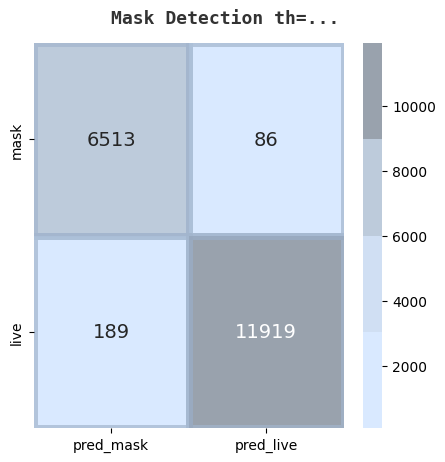

In [9]:
map_score_val_filename = 'test_score_112_M5.txt'
best_threshold = read_calc_plot(map_score_val_filename)

## Saving not correctly labeled images

In [11]:
map_score_val_filename = 'test_score_112_M5.txt'

with open(map_score_val_filename, 'r') as file:
    lines = file.readlines()
val_scores = []
val_labels = []
data = []
count = 0.0
for line in lines:
    # try:
    count += 1
    tokens = line.split()
    score = float(tokens[0])
    label = int(tokens[1])  # int(tokens[1])
    val_scores.append(score)
    val_labels.append(label)

In [12]:
thr = 0.9960611462593079
cnt = 0
inds = []
for i in range(len(val_labels)):
    pred_label = 0 if val_scores[i] < thr else 1
    if val_labels[i]!=pred_label & pred_label == 1:
        # print(i, val_scores[i], val_labels[i], pred_label)
        inds.append(i)
        cnt += 1
print(cnt)

75


In [ ]:
import shutil

# Iterate over each row in the DataFrame
save_fold = "/home/user/ml_projects/Yeldar/results/ssan/wrong_identified_labels"
for i, row in df.loc[inds].iterrows():
    file_path = row['fname']
    print(row['fname'], val_scores[inds[i]])
    # file_path = file_path.replace('/mnt/8TB', '/media/user/685b3289-4051-4530-9827-ef770d2e3f28')
    # Check if the file exists to avoid errors
    if os.path.isfile(file_path):
        shutil.copy(file_path, save_fold)


## Analyzing density plots

In [13]:
import os
import pandas as pd
df = pd.read_csv('data/full_mask_detection_dataset.csv')
# df = df.rename(columns={'image_name': 'fname'})
# df = pd.read_csv('data/completed_test.csv')
df['img_basename'] = df['image_name'].apply(lambda x: os.path.basename(x))
# df[df['label']==1].groupby(['dataset']).count()
df


,image_name,subject,dataset,label,img_basename
0,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1,IDRND,1,real_1_01.png
1,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_10,IDRND,1,real_10_01.png
2,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_100,IDRND,1,real_100_01.png
3,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1000,IDRND,1,real_1000_01.png
4,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1001,IDRND,1,real_1001_01.png
...,...,...,...,...,...
72335,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_75_IMG_6583.jpg
72336,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_80_IMG_6583.jpg
72337,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_90_IMG_6583.jpg
72338,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_95_IMG_6583.jpg


In [16]:
map_score_val_filename = 'test_score_112_M5.txt'

with open(map_score_val_filename, 'r') as file:
    lines = file.readlines()
val_scores = []
val_labels = []
data = []
count = 0.0
for line in lines:
    # try:
    count += 1
    tokens = line.split()
    score = float(tokens[0])
    label = int(tokens[1])  # int(tokens[1])
    val_scores.append(score)

dpath = './data/test_list13.csv'
# dpath = '/mnt/8TB/ml_projects_yeldar/patchnet/train/train_list.csv'
# test_data2 = pd.read_csv(dpath)
test_data = pd.read_csv(dpath)
test_data.columns = ['fname', 'label']
test_data['img_basename'] = test_data['fname'].apply(lambda x: os.path.basename(x))
test_data['score'] = val_scores
test_data

,fname,label,img_basename,score
0,/mnt/8TB/ml_projects_yeldar/patchnet/M1_3_4_te...,0.0,3D-Mask_000208_000001.jpg,0.000024
1,/mnt/8TB/ml_projects_yeldar/patchnet/M1_3_4_te...,1.0,912b7752-c93c-494f-be98-9dea2c6966d7.jpeg,0.999988
2,/mnt/8TB/ml_projects_yeldar/patchnet/M1_3_4_te...,1.0,vid_2983_frameNr_137_Infinix S4_0001e96803--62...,0.999996
3,/mnt/8TB/ml_projects_yeldar/patchnet/M1_3_4_te...,1.0,9bb8de92-1152-40e8-9eef-a113e81ad10d.jpg,0.999995
4,/mnt/8TB/ml_projects_yeldar/patchnet/M1_3_4_te...,0.0,3D-AdultDoll_000071_007422.jpg,0.000097
...,...,...,...,...
18702,/mnt/8TB/ml_projects_yeldar/cropped_youtube_in...,0.0,frameNr_1064_Reginadoll wish you happy new yea...,0.000024
18703,/mnt/8TB/ml_projects_yeldar/cropped_youtube_in...,0.0,frameNr_82_Reginadoll wish you happy new year ...,0.000128
18704,/mnt/8TB/ml_projects_yeldar/cropped_youtube_in...,0.0,frameNr_1007_Reginadoll wish you happy new yea...,0.000040
18705,/mnt/8TB/ml_projects_yeldar/cropped_youtube_in...,0.0,frameNr_184_Reginadoll wish you happy new year...,0.000129


In [ ]:
dpath = './data/tra/test_list11.csv'
# dpath = '/mnt/8TB/ml_projects_yeldar/patchnet/train/train_list.csv'
test_data = pd.read_csv(dpath)
# test_data = pd.read_csv(dpath)
test_data.columns = ['fname', 'label']
test_data[test_data['label']==1]

In [ ]:
test_data = pd.merge(test_data, df, on=['img_basename'], how='left')
# test_data = pd.merge(test_data, test_data2, on=['fname'], how='outer')
test_data = test_data.drop(columns=['label_y', 'image_name'])
test_data = test_data.rename(columns={"label_x":"label"})
test_data
# non_intersecting_rows = test_data[~test_data['fname'].isin(test_data2['fname'])]
# non_intersecting_rows

In [ ]:
test_data[test_data['label']==1].groupby(['dataset'])['score'].describe()
# test_data[test_data['label']==1].groupby(['dataset']).count()

In [ ]:
test_data[test_data['label']==0].groupby(['dataset'])['score'].describe()

In [ ]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=test_data[test_data['label']==1], x="score", hue="dataset", fill=True, common_norm=False, alpha=0.4, legend=True)
plt.title('SSAN_R results on patchnet test data')
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=test_data[test_data['label']==0], x="score", hue="dataset", fill=True, common_norm=False, alpha=0.4, legend=True)
# sns.displot(data=test_data[test_data['label']==1], x="score")
plt.show()

In [ ]:
for dataset in  test_data[test_data['label']==1]['dataset'].unique():
    y_true = np.ones(len( test_data[test_data['label']==1][test_data['dataset']==dataset]['score']))
    y_pred =  test_data[test_data['label']==1][test_data['dataset']==dataset]['score']
    y_pred = [1 if score>best_threshold else 0 for score in y_pred]
    print(dataset,round(sum(y_pred)/len(test_data[test_data['label']==1][test_data['dataset']==dataset]['score']), 3)*100,'%')
    # print(dataset,sum(y_pred), len( test_data[test_data['label']==1][test_data['dataset']==dataset]['score']))


In [ ]:
print('results_with_random_crop_mask \n')

for dataset in  test_data[test_data['label']==0]['dataset'].unique():
    y_true = np.ones(len( test_data[test_data['label']==0][test_data['dataset']==dataset]['score']))
    y_pred =  test_data[test_data['label']==0][test_data['dataset']==dataset]['score']
    y_pred = [1 if score<best_threshold  else 0 for score in y_pred]
    # print(dataset,sum(y_pred), len( test_data[test_data['label']==0][test_data['dataset']==dataset]['score']))
    print(dataset,round(sum(y_pred)/len(test_data[test_data['label']==0][test_data['dataset']==dataset]['score']), 3)*100,'%')
    # print(dataset,round(sum(y_pred)))